#### Import the necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### File open the CSV files and bring them in as their own Data Frames

In [2]:
members =pd.read_csv('../data/NSS_GreatCare_Members.csv')


In [3]:
admissions =pd.read_csv('../data/NSS_Hospital_Inpatient_Admissions.csv')

In [4]:
pcp_visit =pd.read_csv('../data/NSS_PrimaryCare_Office_Visits.csv',low_memory = False)

In [5]:
print('\nMembers Data\n\n')
print(members.info())
print('\n\n------------------------------------------------------------------------------------------\n\n')
print('Admissions Data\n\n')
print(admissions.info())
print('\n\n------------------------------------------------------------------------------------------\n\n')
print('PCP Visit\n\n')
print(pcp_visit.info())


Members Data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61519 entries, 0 to 61518
Data columns (total 63 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Patient ID                                                       61519 non-null  object 
 1   Primary Plan ID                                                  61519 non-null  object 
 2   Primary Payor ID                                                 61519 non-null  object 
 3   Is Patient Alive                                                 61519 non-null  int64  
 4   Patient Age Integer                                              61519 non-null  int64  
 5   Patient Date of Birth                                            61519 non-null  object 
 6   Patient ZIP Code 5-Digit                                         61105 non-null  float64
 7   Count Primary Care Visit

#### Clean up data fields - Getting the House in Orde

In [6]:
# Change Object data type to Dates
members['Period Start Date'] = pd.to_datetime(members['Period Start Date'], format='%Y-%m-%d')
members['Period End Date'] = pd.to_datetime(members['Period End Date'], format='%Y-%m-%d')
members['Patient Date of Birth'] = pd.to_datetime(members['Patient Date of Birth'], format='%Y-%m-%d')
# Drop the Zeros on the Zip and fill in the blank and convert to the string
members['Patient ZIP Code 5-Digit'] = members['Patient ZIP Code 5-Digit'].fillna("0").astype(int).astype(str)
# Add an additional field of 30days after the end date.
#members['days_30'] = members['Period End Date']+ pd.DateOffset(days=30)
# Change Object data type to Dates
admissions['Encounter Start Date'] = pd.to_datetime(admissions['Encounter Start Date'], format='%Y-%m-%d')
admissions['Encounter End Date'] = pd.to_datetime(admissions['Encounter End Date'], format='%Y-%m-%d')
admissions['Attending Provider NPI']=admissions['Attending Provider NPI'].astype(str).str.replace('.0', '', regex=False)
pcp_visit['Encounter Date'] = pd.to_datetime(pcp_visit['Encounter Date'], format='%Y-%m-%d')

In [7]:
admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6213 entries, 0 to 6212
Data columns (total 23 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   Encounter ID                                         6213 non-null   object        
 1   Patient ID                                           6213 non-null   object        
 2   Encounter Primary Payor ID                           6213 non-null   object        
 3   Encounter Primary Plan ID                            6213 non-null   object        
 4   Facility Provider ID                                 6213 non-null   object        
 5   Attending Provider ID                                5884 non-null   object        
 6   Attending Provider NPI                               6213 non-null   object        
 7   Facility Provider NPI                                6213 non-null   object        
 8 

### Take select columns from the dataframes

In [8]:
admissions1 = admissions[['Encounter ID', 'Patient ID', 'Attending Provider NPI',
       'Facility Provider NPI', 'Encounter Start Date', 'Encounter End Date',
       #'Principal Discharge Diagnosis ICD-9-CM Code',
       #'Principal Discharge Diagnosis ICD-9-CM Description',
       'Principal Discharge Diagnosis ICD-10-CM Code',
       'Principal Discharge Diagnosis ICD-10-CM Description',
       #'Primary Plan Allowed Amount', 'Primary Plan Paid Amount',
       'Patient Paid Amount']]

In [9]:
admissions1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6213 entries, 0 to 6212
Data columns (total 9 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   Encounter ID                                         6213 non-null   object        
 1   Patient ID                                           6213 non-null   object        
 2   Attending Provider NPI                               6213 non-null   object        
 3   Facility Provider NPI                                6213 non-null   object        
 4   Encounter Start Date                                 6213 non-null   datetime64[ns]
 5   Encounter End Date                                   6213 non-null   datetime64[ns]
 6   Principal Discharge Diagnosis ICD-10-CM Code         4577 non-null   object        
 7   Principal Discharge Diagnosis ICD-10-CM Description  4522 non-null   object        
 8  

In [10]:
#reduce pcp to relevant columns
pcp1 = pcp_visit[['Encounter ID','Patient ID', 'Attending Provider NPI', 'Service Provider NPI',
          'Provider Group NPI','Encounter Date']]


In [11]:
pcp1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231373 entries, 0 to 231372
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Encounter ID            231373 non-null  object        
 1   Patient ID              231373 non-null  object        
 2   Attending Provider NPI  39644 non-null   float64       
 3   Service Provider NPI    230599 non-null  float64       
 4   Provider Group NPI      227644 non-null  float64       
 5   Encounter Date          231373 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 10.6+ MB


### Problem 1: 30-day Readmission Rate

#### What is our 30-day all cause readmission rate across hospitals our members are admitted to?¶

#### Getting the next admission date for same patient to same line

In [12]:
admissions2 = admissions1
admissions2['next_adm']= admissions2.sort_values(by=['Encounter Start Date'],ascending=True).groupby(['Patient ID']) ['Encounter Start Date'].shift(-1)
admissions2.head(50)
# admissions2['next_adm']= admissions2.sort_values(by=['Encounter Start Date'],ascending=True).groupby(['Patient ID']) ['Encounter Start Date'].shift(-1)
# admissions2.tail(50)

<ipython-input-12-0380320bb9d9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admissions2['next_adm']= admissions2.sort_values(by=['Encounter Start Date'],ascending=True).groupby(['Patient ID']) ['Encounter Start Date'].shift(-1)


,Encounter ID,Patient ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Patient Paid Amount,next_adm
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,1417170523,1306890389,2013-01-12,2013-01-14,O70.0,First degree perineal laceration during delivery,250.0,NaT
1,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,1669599197,1902803315,2014-01-05,2014-01-12,NaN,NaN,250.0,NaT
2,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,1407880511,1902803315,2012-06-13,2012-06-21,K91.71,Accidental puncture and laceration of a digest...,250.0,NaT
3,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,1407008907,1427055839,2012-12-06,2012-12-09,O70.1,Second degree perineal laceration during delivery,250.0,NaT
4,HIA|DS1|10118|DS1|NPI|1992818256|1,DS1|10118,1518045608,1992818256,2015-03-11,2015-03-14,F32.9,"Major depressive disorder, single episode, uns...",0.0,NaT
5,HIA|DS1|10126|DS1|NPI|1902803315|1,DS1|10126,1346556891,1902803315,2010-04-07,2010-04-09,NaN,NaN,250.0,NaT
6,HIA|DS1|10130|DS1|NPI|1427055839|1,DS1|10130,1316989247,1427055839,2014-06-01,2014-06-05,K35.2,Acute appendicitis with generalized peritonitis,250.0,NaT
7,HIA|DS1|10132|DS1|NPI|1366545311|1,DS1|10132,nan,1366545311,2013-08-14,2013-08-16,NaN,NaN,250.0,NaT
8,HIA|DS1|10132|DS1|NPI|1386741635|1,DS1|10132,1417995317,1386741635,2013-03-30,2013-04-01,NaN,NaN,250.0,2013-08-14
9,HIA|DS1|10135|DS1|NPI|1184722779|1,DS1|10135,1396818134,1184722779,2013-08-20,2013-08-22,N85.02,Endometrial intraepithelial neoplasia [EIN],250.0,NaT


In [13]:
#testing output
admissions2[admissions2['Patient ID']=='DS1|10451']

,Encounter ID,Patient ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Patient Paid Amount,next_adm
34,HIA|DS1|10451|DS1|NPI|1023010113|1,DS1|10451,1306902739,1023010113,2014-04-24,2014-04-26,K74.60,Unspecified cirrhosis of liver,250.0,2014-05-23
35,HIA|DS1|10451|DS1|NPI|1063412005|1,DS1|10451,1518963032,1063412005,2013-03-20,2013-03-23,NaN,NaN,250.0,2013-03-27
36,HIA|DS1|10451|DS1|NPI|1225199987|1,DS1|10451,1750425278,1225199987,2014-06-29,2014-06-29,S06.5X9A,Traumatic subdural hemorrhage with loss of con...,0.0,NaT
37,HIA|DS1|10451|DS1|NPI|1427055839|1,DS1|10451,1427344951,1427055839,2013-04-16,2013-04-26,NaN,NaN,50.0,2013-05-01
38,HIA|DS1|10451|DS1|NPI|1427055839|2,DS1|10451,1073566931,1427055839,2013-05-01,2013-05-09,NaN,NaN,0.0,2013-06-25
39,HIA|DS1|10451|DS1|NPI|1427055839|3,DS1|10451,1073566931,1427055839,2013-06-25,2013-07-01,NaN,NaN,0.0,2013-07-26
40,HIA|DS1|10451|DS1|NPI|1427055839|4,DS1|10451,1679541775,1427055839,2013-07-26,2013-08-03,NaN,NaN,0.0,2013-08-31
41,HIA|DS1|10451|DS1|NPI|1427055839|5,DS1|10451,1215189550,1427055839,2013-08-31,2013-09-02,NaN,NaN,0.0,2013-11-14
42,HIA|DS1|10451|DS1|NPI|1427055839|6,DS1|10451,1679541775,1427055839,2013-11-14,2013-11-20,K76.6,Portal hypertension,0.0,2013-12-17
43,HIA|DS1|10451|DS1|NPI|1427055839|7,DS1|10451,1053358127,1427055839,2013-12-17,2013-12-19,R55,Syncope and collapse,250.0,2014-04-24


#### Now that we have the Next Encounter Start Date added to the Current Encounter row. We can Calculate the number of days between the two visits

In [14]:
admissions2['Days Between Re_admission']= admissions2['next_adm'] - admissions2['Encounter End Date']
admissions2

<ipython-input-14-c1d4d0f5edbf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admissions2['Days Between Re_admission']= admissions2['next_adm'] - admissions2['Encounter End Date']


,Encounter ID,Patient ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Patient Paid Amount,next_adm,Days Between Re_admission
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,1417170523,1306890389,2013-01-12,2013-01-14,O70.0,First degree perineal laceration during delivery,250.0,NaT,NaT
1,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,1669599197,1902803315,2014-01-05,2014-01-12,NaN,NaN,250.0,NaT,NaT
2,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,1407880511,1902803315,2012-06-13,2012-06-21,K91.71,Accidental puncture and laceration of a digest...,250.0,NaT,NaT
3,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,1407008907,1427055839,2012-12-06,2012-12-09,O70.1,Second degree perineal laceration during delivery,250.0,NaT,NaT
4,HIA|DS1|10118|DS1|NPI|1992818256|1,DS1|10118,1518045608,1992818256,2015-03-11,2015-03-14,F32.9,"Major depressive disorder, single episode, uns...",0.0,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...
6208,HIA|DS1|9979|DS1|NPI|1689772592|1,DS1|9979,1720043417,1689772592,2015-02-06,2015-02-11,O44.13,"Complete placenta previa with hemorrhage, thir...",250.0,NaT,NaT
6209,HIA|DS1|9981|DS1|NPI|1427055839|1,DS1|9981,1215968474,1427055839,2014-08-07,2014-08-10,NaN,NaN,250.0,NaT,NaT
6210,HIA|DS1|9994|DS1|NPI|1689608150|1,DS1|9994,1861831836,1689608150,2015-11-21,2015-11-23,O76,Abnormality in fetal heart rate and rhythm com...,250.0,2015-11-24,1 days
6211,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,1750544516,1689608150,2015-11-24,2015-11-27,O42.92,"Full-term premature rupture of membranes, unsp...",250.0,NaT,NaT


#### Drop all rows that have no Values in the Admission 2 Data Frame in the 'next_adm' or 'Days between Readmission' as they were not Re-admitted

In [15]:
re_admits = admissions2.dropna(subset=['next_adm'])
re_admits

,Encounter ID,Patient ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Patient Paid Amount,next_adm,Days Between Re_admission
8,HIA|DS1|10132|DS1|NPI|1386741635|1,DS1|10132,1417995317,1386741635,2013-03-30,2013-04-01,NaN,NaN,250.0,2013-08-14,135 days
18,HIA|DS1|10253|DS1|NPI|1396725677|1,DS1|10253,1932127248,1396725677,2010-06-02,2010-06-06,NaN,NaN,250.0,2011-10-15,496 days
19,HIA|DS1|10253|DS1|NPI|1689772592|1,DS1|10253,1346566221,1689772592,2010-04-02,2010-04-16,NaN,NaN,250.0,2010-06-02,47 days
20,HIA|DS1|10291|DS1|NPI|1821250762|1,DS1|10291,1598993990,1821250762,2010-05-14,2010-05-15,NaN,NaN,250.0,2011-02-24,285 days
34,HIA|DS1|10451|DS1|NPI|1023010113|1,DS1|10451,1306902739,1023010113,2014-04-24,2014-04-26,K74.60,Unspecified cirrhosis of liver,250.0,2014-05-23,27 days
...,...,...,...,...,...,...,...,...,...,...,...
6198,HIA|DS1|9935|DS1|NPI|1669456299|1,DS1|9935,1376864215,1669456299,2011-01-22,2011-01-24,I77.3,Arterial fibromuscular dysplasia,250.0,2011-01-25,1 days
6199,HIA|DS1|9935|DS1|NPI|1902803315|1,DS1|9935,1972545085,1902803315,2011-01-25,2011-01-26,I63.211,Cerebral infarction due to unspecified occlusi...,250.0,2011-01-26,0 days
6201,HIA|DS1|9943|DS1|NPI|1184722779|1,DS1|9943,1932297231,1184722779,2013-10-01,2013-10-16,K95.09,Other complications of gastric band procedure,160.0,2013-10-25,9 days
6202,HIA|DS1|9943|DS1|NPI|1184722779|2,DS1|9943,1942320288,1184722779,2013-10-25,2013-10-28,K91.89,Other postprocedural complications and disorde...,0.0,2014-10-28,365 days


In [16]:
# the Dataframe does contain negative values in the Days between Readmission as well as we need to 
# find the records that are 0 - 30 days.
re_admits_under30d = re_admits[(re_admits['Days Between Re_admission'] <= dt.timedelta(days = 30)) & (re_admits['Days Between Re_admission'] >= dt.timedelta(days = 0)) ]
re_admits_under30d.head(50) 

,Encounter ID,Patient ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Patient Paid Amount,next_adm,Days Between Re_admission
34,HIA|DS1|10451|DS1|NPI|1023010113|1,DS1|10451,1306902739,1023010113,2014-04-24,2014-04-26,K74.60,Unspecified cirrhosis of liver,250.0,2014-05-23,27 days
35,HIA|DS1|10451|DS1|NPI|1063412005|1,DS1|10451,1518963032,1063412005,2013-03-20,2013-03-23,NaN,NaN,250.0,2013-03-27,4 days
37,HIA|DS1|10451|DS1|NPI|1427055839|1,DS1|10451,1427344951,1427055839,2013-04-16,2013-04-26,NaN,NaN,50.0,2013-05-01,5 days
39,HIA|DS1|10451|DS1|NPI|1427055839|3,DS1|10451,1073566931,1427055839,2013-06-25,2013-07-01,NaN,NaN,0.0,2013-07-26,25 days
40,HIA|DS1|10451|DS1|NPI|1427055839|4,DS1|10451,1679541775,1427055839,2013-07-26,2013-08-03,NaN,NaN,0.0,2013-08-31,28 days
42,HIA|DS1|10451|DS1|NPI|1427055839|6,DS1|10451,1679541775,1427055839,2013-11-14,2013-11-20,K76.6,Portal hypertension,0.0,2013-12-17,27 days
45,HIA|DS1|10451|DS1|NPI|1902844988|1,DS1|10451,1811123151,1902844988,2013-03-27,2013-04-16,NaN,NaN,250.0,2013-04-16,0 days
51,HIA|DS1|10507|DS1|NPI|1902803315|1,DS1|10507,1750312146,1902803315,2012-11-10,2012-11-16,O24.424,"Gestational diabetes mellitus in childbirth, i...",250.0,2012-11-20,4 days
66,HIA|DS1|10698|DS1|NPI|1902803315|1,DS1|10698,1295777282,1902803315,2012-01-03,2012-01-04,J06.9,"Acute upper respiratory infection, unspecified",250.0,2012-01-04,0 days
70,HIA|DS1|10707|DS1|NPI|1033298617|2,DS1|10707,1932230810,1033298617,2010-07-25,2010-07-27,Q87.2,Congenital malformation syndromes predominantl...,0.0,2010-08-13,17 days


In [17]:
# Identify the records in the Re-admission DF
repeat_admissons = len(re_admits_under30d.index)
print('Repeat Admissions count is ',repeat_admissons)
# Identify the records in the admissions DF
total_hospitalizations = len(admissions1.index)
print('Total Admissions count is ',total_hospitalizations)
# To calculate the percentage
perc_readmission = round((repeat_admissons/total_hospitalizations) *100 , 3)
print('The percentage of Readmission in the last 30 days is ',perc_readmission)

Repeat Admissions count is  696
Total Admissions count is  6213
The percentage of Readmission in the last 30 days is  11.202


In [18]:
# g = sns.lineplot(x = 'Encounter Month', y = 'Under 30 Days Rate', data = monthly_u30_rates)
# g.set(xlim = (pd.to_datetime('2008-12-31'),None))

In [19]:
#Create a graphical review of the Re-admission Rate by Month
#I will need to make two separate data frames ( Under 30days Readmission encounters )
#and (all admission encounters) then merge it into one table to form a table that can 
#be graphically represented appropriately
# To group by date time, there is a function called grouper
u_30days = re_admits_under30d.groupby(pd.Grouper(key ='Encounter End Date',freq="M"))['Encounter ID'].count()  # DataFrameGroupBy (grouped by Month) and Count
Under_30days = pd.DataFrame(u_30days).reset_index()
Under_30days
#102 months of data was discovered
#Rename the Column Headers and prepare it for future Merge
Under_30days = Under_30days.rename(columns = {'Encounter End Date':'Encounter Month','Encounter ID':'30 Days Re_admits'})
Under_30days 

,Encounter Month,30 Days Re_admits
0,2009-12-31,6
1,2010-01-31,2
2,2010-02-28,0
3,2010-03-31,3
4,2010-04-30,10
...,...,...
97,2018-01-31,1
98,2018-02-28,0
99,2018-03-31,1
100,2018-04-30,1


In [20]:
# Our first Data Frame is now built and Lets build the all encounters data frame grouped by month
all_enc = admissions2.groupby(pd.Grouper(key ='Encounter End Date',freq="M"))['Encounter ID'].count()  # DataFrameGroupBy (grouped by Month) and Count))
all_encounters = pd.DataFrame(all_enc).reset_index() #Converting the list into a dataframe and reseting the index
all_encounters = all_encounters.rename(columns = {'Encounter End Date':'Encounter Month','Encounter ID':'All Admission Count'})
# We have 115 months vs 102months for Under 30 days
all_encounters

,Encounter Month,All Admission Count
0,2009-11-30,2
1,2009-12-31,26
2,2010-01-31,45
3,2010-02-28,30
4,2010-03-31,31
...,...,...
110,2019-01-31,1
111,2019-02-28,4
112,2019-03-31,0
113,2019-04-30,1


In [21]:
# Now Merge the two dataframes to find the rate of Re-admits
monthly_re_admit_rates = pd.merge(all_encounters, Under_30days, on='Encounter Month', how='left'  )
monthly_re_admit_rates["30 Days Re_admits"].fillna(0,inplace=True)

#Create a new Column with the dataframe to calculate Percentage 30days Re-admits
monthly_re_admit_rates['30days Re_admit Rate']= round((monthly_re_admit_rates['30 Days Re_admits'] /
                                                    monthly_re_admit_rates['All Admission Count'] *100),2)
monthly_re_admit_rates.tail(30)
                                                    

,Encounter Month,All Admission Count,30 Days Re_admits,30days Re_admit Rate
85,2016-12-31,12,1.0,8.33
86,2017-01-31,20,5.0,25.00
87,2017-02-28,22,6.0,27.27
88,2017-03-31,13,3.0,23.08
89,2017-04-30,19,5.0,26.32
90,2017-05-31,12,1.0,8.33
91,2017-06-30,5,0.0,0.00
92,2017-07-31,7,0.0,0.00
93,2017-08-31,11,3.0,27.27
94,2017-09-30,11,3.0,27.27


[(14244.0, 18220.45)]

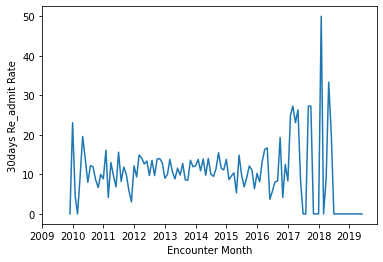

In [22]:
g = sns.lineplot(x = 'Encounter Month', y = '30days Re_admit Rate', data = monthly_re_admit_rates)
g.set(xlim = (pd.to_datetime('2008-12-31'), None))# This allows the timeline to start at 2009

### Problem 2. What percent of patients have a PCP visit within a week of discharge?

In [23]:
# We will merge admission data frame with pcp visit dataframe to determine the whether a patient visited their PCP.
#pcp_visit.head()
# reduce columns that are required
pcp1.head()
admits_pcp = pd.merge(admissions2,pcp1, how='left', on = 'Patient ID', suffixes=('','_pcp'))
admits_pcp


,Encounter ID,Patient ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Patient Paid Amount,next_adm,Days Between Re_admission,Encounter ID_pcp,Attending Provider NPI_pcp,Service Provider NPI,Provider Group NPI,Encounter Date
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,1417170523,1306890389,2013-01-12,2013-01-14,O70.0,First degree perineal laceration during delivery,250.0,NaT,NaT,COV|PBSL|DS1|10033|P|1228384|1043427248|1|SHIFTED,NaN,1.619980e+09,1.043427e+09,2015-12-08
1,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,1417170523,1306890389,2013-01-12,2013-01-14,O70.0,First degree perineal laceration during delivery,250.0,NaT,NaT,COV|PBSL|DS1|10033|P|1326684|1043427248|1|SHIFTED,NaN,1.225216e+09,1.043427e+09,2012-06-18
2,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,1417170523,1306890389,2013-01-12,2013-01-14,O70.0,First degree perineal laceration during delivery,250.0,NaT,NaT,COV|PBSL|DS1|10033|P|155317|1043427248|1|SHIFTED,NaN,1.619980e+09,1.043427e+09,2014-06-10
3,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,1417170523,1306890389,2013-01-12,2013-01-14,O70.0,First degree perineal laceration during delivery,250.0,NaT,NaT,COV|PBSL|DS1|10033|P|439093|1043427248|1|SHIFTED,NaN,1.366453e+09,1.043427e+09,2014-09-28
4,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,1417170523,1306890389,2013-01-12,2013-01-14,O70.0,First degree perineal laceration during delivery,250.0,NaT,NaT,COV|PBSL|DS1|10033|P|711310|1043427248|1|SHIFTED,NaN,1.619980e+09,1.043427e+09,2014-03-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44093,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,1750544516,1689608150,2015-11-24,2015-11-27,O42.92,"Full-term premature rupture of membranes, unsp...",250.0,NaT,NaT,COV|PCSL|DS1|9994|P|1238517|1407058787|2,NaN,1.487735e+09,1.407059e+09,2015-12-05
44094,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,1750544516,1689608150,2015-11-24,2015-11-27,O42.92,"Full-term premature rupture of membranes, unsp...",250.0,NaT,NaT,COV|PCSL|DS1|9994|P|302749|1407058787|2,NaN,1.487735e+09,1.407059e+09,2015-12-13
44095,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,1750544516,1689608150,2015-11-24,2015-11-27,O42.92,"Full-term premature rupture of membranes, unsp...",250.0,NaT,NaT,COV|PCSL|DS1|9994|P|781849|1205884392|1,NaN,1.669553e+09,1.205884e+09,2014-05-18
44096,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,1750544516,1689608150,2015-11-24,2015-11-27,O42.92,"Full-term premature rupture of membranes, unsp...",250.0,NaT,NaT,COV|PCSL|DS1|9994|P|93182|1043427248|1,NaN,1.508895e+09,1.043427e+09,2013-07-20


In [24]:
admits_pcp['Hospital to PCP Days'] = admits_pcp['Encounter Date'] - admits_pcp['Encounter End Date']
admits_pcp

,Encounter ID,Patient ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Patient Paid Amount,next_adm,Days Between Re_admission,Encounter ID_pcp,Attending Provider NPI_pcp,Service Provider NPI,Provider Group NPI,Encounter Date,Hospital to PCP Days
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,1417170523,1306890389,2013-01-12,2013-01-14,O70.0,First degree perineal laceration during delivery,250.0,NaT,NaT,COV|PBSL|DS1|10033|P|1228384|1043427248|1|SHIFTED,NaN,1.619980e+09,1.043427e+09,2015-12-08,1058 days
1,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,1417170523,1306890389,2013-01-12,2013-01-14,O70.0,First degree perineal laceration during delivery,250.0,NaT,NaT,COV|PBSL|DS1|10033|P|1326684|1043427248|1|SHIFTED,NaN,1.225216e+09,1.043427e+09,2012-06-18,-210 days
2,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,1417170523,1306890389,2013-01-12,2013-01-14,O70.0,First degree perineal laceration during delivery,250.0,NaT,NaT,COV|PBSL|DS1|10033|P|155317|1043427248|1|SHIFTED,NaN,1.619980e+09,1.043427e+09,2014-06-10,512 days
3,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,1417170523,1306890389,2013-01-12,2013-01-14,O70.0,First degree perineal laceration during delivery,250.0,NaT,NaT,COV|PBSL|DS1|10033|P|439093|1043427248|1|SHIFTED,NaN,1.366453e+09,1.043427e+09,2014-09-28,622 days
4,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,1417170523,1306890389,2013-01-12,2013-01-14,O70.0,First degree perineal laceration during delivery,250.0,NaT,NaT,COV|PBSL|DS1|10033|P|711310|1043427248|1|SHIFTED,NaN,1.619980e+09,1.043427e+09,2014-03-16,426 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44093,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,1750544516,1689608150,2015-11-24,2015-11-27,O42.92,"Full-term premature rupture of membranes, unsp...",250.0,NaT,NaT,COV|PCSL|DS1|9994|P|1238517|1407058787|2,NaN,1.487735e+09,1.407059e+09,2015-12-05,8 days
44094,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,1750544516,1689608150,2015-11-24,2015-11-27,O42.92,"Full-term premature rupture of membranes, unsp...",250.0,NaT,NaT,COV|PCSL|DS1|9994|P|302749|1407058787|2,NaN,1.487735e+09,1.407059e+09,2015-12-13,16 days
44095,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,1750544516,1689608150,2015-11-24,2015-11-27,O42.92,"Full-term premature rupture of membranes, unsp...",250.0,NaT,NaT,COV|PCSL|DS1|9994|P|781849|1205884392|1,NaN,1.669553e+09,1.205884e+09,2014-05-18,-558 days
44096,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,1750544516,1689608150,2015-11-24,2015-11-27,O42.92,"Full-term premature rupture of membranes, unsp...",250.0,NaT,NaT,COV|PCSL|DS1|9994|P|93182|1043427248|1,NaN,1.508895e+09,1.043427e+09,2013-07-20,-860 days


In [25]:
#cut out all rows with negative time in Hospital to PCP Days, but keep na rows (people who never saw PCP)
pcp_after_hospitalization = admits_pcp[(admits_pcp['Hospital to PCP Days'] >= dt.timedelta(days = 0))]

print('Count after removals of negatives = ',len(pcp_after_hospitalization))
#cut out all rows with higher than 7 days in the Hospital to PCP Days.
pcp_after_hospitalization = pcp_after_hospitalization[(pcp_after_hospitalization['Hospital to PCP Days'] <= dt.timedelta(days = 7))]
print('Count after less than Equal 7 days = ',len(pcp_after_hospitalization))
pcp_after_hospitalization

Count after removals of negatives =  23657
Count after less than Equal 7 days =  2375


,Encounter ID,Patient ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Patient Paid Amount,next_adm,Days Between Re_admission,Encounter ID_pcp,Attending Provider NPI_pcp,Service Provider NPI,Provider Group NPI,Encounter Date,Hospital to PCP Days
17,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,1669599197,1902803315,2014-01-05,2014-01-12,NaN,NaN,250.0,NaT,NaT,COV|PBSL|DS1|10043|P|538933|1043427248|1|SHIFTED,NaN,1.619200e+09,1.043427e+09,2014-01-12,0 days
28,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,1407880511,1902803315,2012-06-13,2012-06-21,K91.71,Accidental puncture and laceration of a digest...,250.0,NaT,NaT,COV|PBSL|DS1|10073|P|301709|1043427248|1|SHIFTED,NaN,1.659394e+09,1.043427e+09,2012-06-27,6 days
50,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,1407008907,1427055839,2012-12-06,2012-12-09,O70.1,Second degree perineal laceration during delivery,250.0,NaT,NaT,COV|PCSL|DS1|10101|P|1189971|1043427248|1,NaN,1.952538e+09,1.043427e+09,2012-12-12,3 days
231,HIA|DS1|10303|DS1|NPI|1710918545|1,DS1|10303,1508841602,1710918545,2012-06-21,2012-06-24,O70.1,Second degree perineal laceration during delivery,250.0,NaT,NaT,COV|PBSL|DS1|10303|P|10896|1912987553|1,NaN,1.447235e+09,1.912988e+09,2012-06-30,6 days
238,HIA|DS1|10303|DS1|NPI|1710918545|1,DS1|10303,1508841602,1710918545,2012-06-21,2012-06-24,O70.1,Second degree perineal laceration during delivery,250.0,NaT,NaT,COV|PBSL|DS1|10303|P|48671|1912987553|1,NaN,1.164408e+09,1.912988e+09,2012-06-28,4 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44051,HIA|DS1|9945|DS1|NPI|1902803315|1,DS1|9945,1104144120,1902803315,2013-02-09,2013-02-11,O48.0,Post-term pregnancy,250.0,NaT,NaT,COV|PCSL|DS1|9945|P|840374|1043427248|1,NaN,1.164698e+09,1.043427e+09,2013-02-14,3 days
44067,HIA|DS1|9978|DS1|NPI|1427055839|1,DS1|9978,1316989247,1427055839,2015-09-01,2015-09-05,NaN,NaN,250.0,NaT,NaT,COV|PCSL|DS1|9978|P|696226|1043427248|1,NaN,1.144275e+09,1.043427e+09,2015-09-11,6 days
44071,HIA|DS1|9979|DS1|NPI|1689772592|1,DS1|9979,1720043417,1689772592,2015-02-06,2015-02-11,O44.13,"Complete placenta previa with hemorrhage, thir...",250.0,NaT,NaT,COV|PCSL|DS1|9979|P|281365|1477666352|1,NaN,1.740278e+09,1.477666e+09,2015-02-15,4 days
44074,HIA|DS1|9981|DS1|NPI|1427055839|1,DS1|9981,1215968474,1427055839,2014-08-07,2014-08-10,NaN,NaN,250.0,NaT,NaT,COV|PCSL|DS1|9981|P|1094367|1043427248|1,NaN,1.992932e+09,1.043427e+09,2014-08-11,1 days


In [26]:
# There are several patients that see thier PCP several times a year. Therefore, those duplicates have to be removed
# Along with thier Encounter End Date since we utilize that column for our further calculations
pcp_after_hospitalization = pcp_after_hospitalization.drop_duplicates(subset=['Patient ID','Encounter End Date'],keep='first')

pcp_after_hospitalization

,Encounter ID,Patient ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Patient Paid Amount,next_adm,Days Between Re_admission,Encounter ID_pcp,Attending Provider NPI_pcp,Service Provider NPI,Provider Group NPI,Encounter Date,Hospital to PCP Days
17,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,1669599197,1902803315,2014-01-05,2014-01-12,NaN,NaN,250.0,NaT,NaT,COV|PBSL|DS1|10043|P|538933|1043427248|1|SHIFTED,NaN,1.619200e+09,1.043427e+09,2014-01-12,0 days
28,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,1407880511,1902803315,2012-06-13,2012-06-21,K91.71,Accidental puncture and laceration of a digest...,250.0,NaT,NaT,COV|PBSL|DS1|10073|P|301709|1043427248|1|SHIFTED,NaN,1.659394e+09,1.043427e+09,2012-06-27,6 days
50,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,1407008907,1427055839,2012-12-06,2012-12-09,O70.1,Second degree perineal laceration during delivery,250.0,NaT,NaT,COV|PCSL|DS1|10101|P|1189971|1043427248|1,NaN,1.952538e+09,1.043427e+09,2012-12-12,3 days
231,HIA|DS1|10303|DS1|NPI|1710918545|1,DS1|10303,1508841602,1710918545,2012-06-21,2012-06-24,O70.1,Second degree perineal laceration during delivery,250.0,NaT,NaT,COV|PBSL|DS1|10303|P|10896|1912987553|1,NaN,1.447235e+09,1.912988e+09,2012-06-30,6 days
247,HIA|DS1|10305|DS1|NPI|1184722779|1,DS1|10305,1730127069,1184722779,2014-05-10,2014-05-12,NaN,NaN,250.0,NaT,NaT,COV|PBSL|DS1|10305|P|823298|1184722779|1,NaN,1.417113e+09,1.184723e+09,2014-05-13,1 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44039,HIA|DS1|9943|DS1|NPI|1184722779|3,DS1|9943,1265649966,1184722779,2014-10-28,2014-10-30,K43.0,"Incisional hernia with obstruction, without ga...",500.0,NaT,NaT,COV|PCSL|DS1|9943|P|1315984|1184722779|1,NaN,1.659330e+09,1.184723e+09,2014-11-03,4 days
44051,HIA|DS1|9945|DS1|NPI|1902803315|1,DS1|9945,1104144120,1902803315,2013-02-09,2013-02-11,O48.0,Post-term pregnancy,250.0,NaT,NaT,COV|PCSL|DS1|9945|P|840374|1043427248|1,NaN,1.164698e+09,1.043427e+09,2013-02-14,3 days
44067,HIA|DS1|9978|DS1|NPI|1427055839|1,DS1|9978,1316989247,1427055839,2015-09-01,2015-09-05,NaN,NaN,250.0,NaT,NaT,COV|PCSL|DS1|9978|P|696226|1043427248|1,NaN,1.144275e+09,1.043427e+09,2015-09-11,6 days
44071,HIA|DS1|9979|DS1|NPI|1689772592|1,DS1|9979,1720043417,1689772592,2015-02-06,2015-02-11,O44.13,"Complete placenta previa with hemorrhage, thir...",250.0,NaT,NaT,COV|PCSL|DS1|9979|P|281365|1477666352|1,NaN,1.740278e+09,1.477666e+09,2015-02-15,4 days


In [27]:
oneweek_pcp = len(pcp_after_hospitalization)
print('No. of Patients visit a PCP ',oneweek_pcp)
total_hospitalizations = len(admissions1.index)
print('Total Admissions count is ',total_hospitalizations)
pcp_perc = round((oneweek_pcp/total_hospitalizations)*100,2)
print('% of Patients had a PCP visit within a week of discharge ', pcp_perc)

No. of Patients visit a PCP  1863
Total Admissions count is  6213
% of Patients had a PCP visit within a week of discharge  29.99


### 3. Do either vary by individual or group PCP's?

Problem 3 is pretty vaguely worded. I understand it as asking two questions:    
(a) Does the 30-day readmission rate vary by hospital (which is how I interpreted the word "individual" there)?    
(b) Does the 7-day PCP visit rate vary by PCP Provider Group?     
Is this how everyone else is approaching this problem?    

##### A. Lets us review re-hospitalization by Hospital group

In [28]:
re_admits_facility = re_admits.groupby(by="Facility Provider NPI",as_index=False)['Encounter ID'].count()
re_admits_facility

,Facility Provider NPI,Encounter ID
0,0000000000,36
1,1013062769,1
2,1013906221,2
3,1023010113,1
4,1023065729,2
...,...,...
118,1972541498,3
119,1992818256,20
120,EI11111111,1
121,EI26275047,2


In [29]:
# We will use the admissions1 Dataframe (ALL PATIENTS THAT WENT TO THE HOSPITAL) to group it by Hospital NPI to see if we create a denominator for the above Re-admissions data
Facility_admits = admissions1.groupby(by='Facility Provider NPI',as_index=False)['Encounter ID'].count()
Facility_admits


,Facility Provider NPI,Encounter ID
0,0000000000,103
1,1003878539,1
2,1003961251,2
3,1003980350,1
4,1013062769,1
...,...,...
215,EI26275047,2
216,EI26439240,1
217,EI95472322,1
218,EI95488125,3


In [30]:
#We will now merge the facility admits ( to have denominator) to the re-admits-facility ( numerator)to calculate
#rate of the % re-admission by facility NPI over time.

rehospitalization = pd.merge(Facility_admits, re_admits_facility, how ='left',on='Facility Provider NPI',suffixes =('_hosp', '_readm'))
#Select only the Ecounter ID columns
rehospitalization = rehospitalization[['Facility Provider NPI','Encounter ID_readm','Encounter ID_hosp']]

#Calulate the RE-Hospitalization rate 
rehospitalization['Re_hospitalization_rate'] = round((rehospitalization['Encounter ID_readm'] / rehospitalization['Encounter ID_hosp'] * 100 ) ,2 )

rehospitalization

,Facility Provider NPI,Encounter ID_readm,Encounter ID_hosp,Re_hospitalization_rate
0,0000000000,36.0,103,34.95
1,1003878539,NaN,1,NaN
2,1003961251,NaN,2,NaN
3,1003980350,NaN,1,NaN
4,1013062769,1.0,1,100.00
...,...,...,...,...
215,EI26275047,2.0,2,100.00
216,EI26439240,NaN,1,NaN
217,EI95472322,NaN,1,NaN
218,EI95488125,1.0,3,33.33


In [31]:
# Sort the Re-hospitalization rate
rehospitalization = rehospitalization.sort_values(['Re_hospitalization_rate'], ascending=False)
rehospitalization

,Facility Provider NPI,Encounter ID_readm,Encounter ID_hosp,Re_hospitalization_rate
45,1184612764,1.0,1,100.0
42,1154715845,1.0,1,100.0
157,1780614685,1.0,1,100.0
50,1194840421,1.0,1,100.0
178,1851370910,1.0,1,100.0
...,...,...,...,...
212,EI03040542,NaN,1,NaN
214,EI22222222,NaN,2,NaN
216,EI26439240,NaN,1,NaN
217,EI95472322,NaN,1,NaN


In [32]:
# to identify Hospitals that have > 10 encounters but also have a high admission rate. 

rehospitalization2 = rehospitalization[rehospitalization['Encounter ID_hosp'] >= 10].sort_values(['Re_hospitalization_rate'], ascending=False)
rehospitalization2


,Facility Provider NPI,Encounter ID_readm,Encounter ID_hosp,Re_hospitalization_rate
199,1952546616,7.0,10,70.00
16,1053351916,6.0,11,54.55
131,1639172372,10.0,20,50.00
74,1336328244,5.0,10,50.00
156,1770532608,5.0,11,45.45
87,1407828429,4.0,10,40.00
97,1467459776,6.0,16,37.50
34,1124026273,6.0,16,37.50
62,1265814065,4.0,11,36.36
177,1841277704,4.0,11,36.36


In [33]:
# check my work above
re_admits[re_admits['Facility Provider NPI'] == '1952546616']


,Encounter ID,Patient ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Patient Paid Amount,next_adm,Days Between Re_admission
438,HIA|DS1|13593|DS1|NPI|1952546616|1,DS1|13593,1386651867,1952546616,2011-12-19,2011-12-22,N82.3,Fistula of vagina to large intestine,250.00,2012-01-03,12 days
439,HIA|DS1|13593|DS1|NPI|1952546616|2,DS1|13593,1386651867,1952546616,2012-01-03,2012-01-09,K94.19,Other complications of enterostomy,0.00,2012-01-26,17 days
440,HIA|DS1|13593|DS1|NPI|1952546616|3,DS1|13593,1386651867,1952546616,2012-01-26,2012-02-09,K60.4,Rectal fistula,250.00,2012-02-12,3 days
441,HIA|DS1|13593|DS1|NPI|1952546616|4,DS1|13593,1386651867,1952546616,2012-02-12,2012-02-14,L27.0,Generalized skin eruption due to drugs and med...,0.00,2012-02-22,8 days
442,HIA|DS1|13593|DS1|NPI|1952546616|5,DS1|13593,1386651867,1952546616,2012-02-22,2012-03-11,K60.4,Rectal fistula,209.61,2012-03-18,7 days
443,HIA|DS1|13593|DS1|NPI|1952546616|6,DS1|13593,1386651867,1952546616,2012-03-18,2012-03-24,T81.4XXA,NaN,0.00,2012-04-17,24 days
444,HIA|DS1|13593|DS1|NPI|1952546616|7,DS1|13593,1386651867,1952546616,2012-04-17,2012-05-06,K60.4,Rectal fistula,0.00,2012-05-08,2 days


In [34]:
# Identify the Top Ten Facility NPI with > 10 encounters per Facility NPI
top_ten_readmission_NPI = rehospitalization2.nlargest(10,'Re_hospitalization_rate')
top_ten_readmission_NPI

,Facility Provider NPI,Encounter ID_readm,Encounter ID_hosp,Re_hospitalization_rate
199,1952546616,7.0,10,70.00
16,1053351916,6.0,11,54.55
131,1639172372,10.0,20,50.00
74,1336328244,5.0,10,50.00
156,1770532608,5.0,11,45.45
87,1407828429,4.0,10,40.00
97,1467459776,6.0,16,37.50
34,1124026273,6.0,16,37.50
62,1265814065,4.0,11,36.36
177,1841277704,4.0,11,36.36


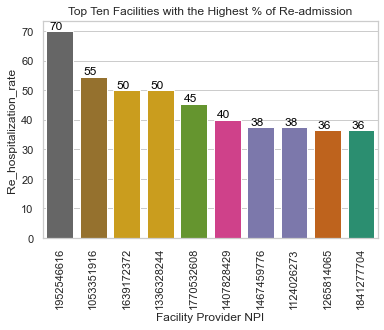

In [35]:

sns.set_theme(style="whitegrid")
g = sns.barplot(x='Facility Provider NPI', y='Re_hospitalization_rate',  data=top_ten_readmission_NPI, palette="Dark2_r")
plt.title('Top Ten Facilities with the Highest % of Re-admission')
plt.xticks(rotation=90)
for p in g.patches:
        g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')

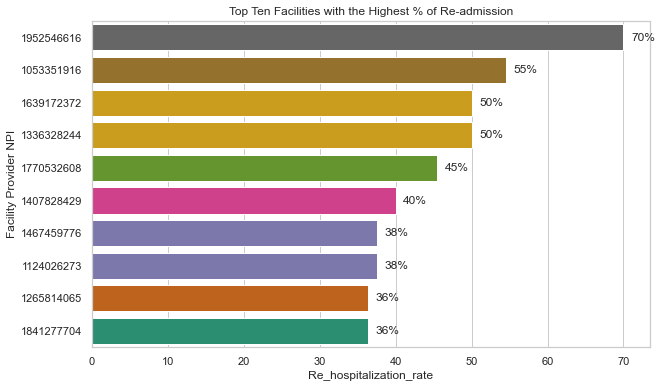

In [36]:
#The Above Graph represented Horizontally
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
g = sns.barplot(x='Re_hospitalization_rate', y='Facility Provider NPI',  data=top_ten_readmission_NPI, palette="Dark2_r")
plt.title('Top Ten Facilities with the Highest % of Re-admission')

for p in g.patches:
    width = p.get_width()    # get bar length
    g.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}%'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

#### B. Lets Review Re-Hospitalization by Attending Provider

In [37]:
re_admits_facility2 = re_admits.groupby(by="Attending Provider NPI",as_index=False)['Encounter ID'].count()
re_admits_facility2

,Attending Provider NPI,Encounter ID
0,1003019001,3
1,1003045600,2
2,1003172529,1
3,1003873720,2
4,1003899642,1
...,...,...
808,1992913222,1
809,1992926620,1
810,1992940969,1
811,1992970206,1


In [38]:
# We will use the admissions1 Dataframe (ALL PATIENTS THAT WENT TO THE HOSPITAL) to group it by Hospital NPI to see if we create a denominator for the above Re-admissions data
Facility_admits2 = admissions1.groupby(by='Attending Provider NPI',as_index=False)['Encounter ID'].count()
Facility_admits2
#1931 rows

,Attending Provider NPI,Encounter ID
0,1003012444,2
1,1003019001,19
2,1003045600,3
3,1003172529,1
4,1003172552,1
...,...,...
1927,1992940969,2
1928,1992970206,3
1929,1992972897,1
1930,1992997977,1


In [39]:
#We will now merge the facility admits2 ( to have denominator) to the re-admits-facility ( numerator)to calculate
#rate of the % re-admission by facility NPI over time.

provider_hosp = pd.merge(Facility_admits2, re_admits_facility2, how ='left',on='Attending Provider NPI',suffixes =('_hosp', '_readm'))
#Select only the Ecounter ID columns
provider_hosp = provider_hosp[['Attending Provider NPI','Encounter ID_readm','Encounter ID_hosp']]

#Calulate the RE-Hospitalization rate 
provider_hosp['Re_hospitalization_rate'] = round((provider_hosp['Encounter ID_readm'] / provider_hosp['Encounter ID_hosp'] * 100 ) ,2 )
# Sort the Re-hospitalization rate
provider_hosp = provider_hosp.sort_values(['Re_hospitalization_rate'], ascending=False)
provider_hosp

,Attending Provider NPI,Encounter ID_readm,Encounter ID_hosp,Re_hospitalization_rate
1411,1720141153,1.0,1,100.0
1710,1881918654,1.0,1,100.0
1171,1588744072,1.0,1,100.0
649,1336203496,1.0,1,100.0
648,1336197730,1.0,1,100.0
...,...,...,...,...
1920,1992885040,NaN,3,NaN
1922,1992905178,NaN,2,NaN
1926,1992932388,NaN,1,NaN
1929,1992972897,NaN,1,NaN


In [40]:
# to identify Attending Provider that have > 10 encounters but also have a high admission rate. 

provider_hosp2 = provider_hosp[provider_hosp['Encounter ID_hosp'] >= 10].sort_values(['Re_hospitalization_rate'], ascending=False)

provider_hosp2

,Attending Provider NPI,Encounter ID_readm,Encounter ID_hosp,Re_hospitalization_rate
663,1346276870,7.0,11,63.64
1130,1568574937,7.0,12,58.33
1332,1679541775,17.0,34,50.00
527,1265634604,6.0,12,50.00
814,1417061797,19.0,39,48.72
...,...,...,...,...
1166,1588648877,NaN,11,NaN
1192,1598852014,NaN,16,NaN
1293,1659344224,NaN,13,NaN
1387,1700964566,NaN,10,NaN


In [41]:
provider_hosp2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 663 to 1775
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Attending Provider NPI   99 non-null     object 
 1   Encounter ID_readm       90 non-null     float64
 2   Encounter ID_hosp        99 non-null     int64  
 3   Re_hospitalization_rate  90 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.9+ KB


In [42]:
# Identify the Top Ten Facility NPI with > 10 encounters per Facility NPI
top_ten_readmission_prov_NPI = provider_hosp2.nlargest(10,'Re_hospitalization_rate')
top_ten_readmission_prov_NPI

,Attending Provider NPI,Encounter ID_readm,Encounter ID_hosp,Re_hospitalization_rate
663,1346276870,7.0,11,63.64
1130,1568574937,7.0,12,58.33
1332,1679541775,17.0,34,50.00
527,1265634604,6.0,12,50.00
814,1417061797,19.0,39,48.72
1801,1932307808,16.0,37,43.24
805,1407880511,5.0,12,41.67
577,1295777282,7.0,17,41.18
1319,1669552840,11.0,27,40.74
20,1013113679,4.0,10,40.00


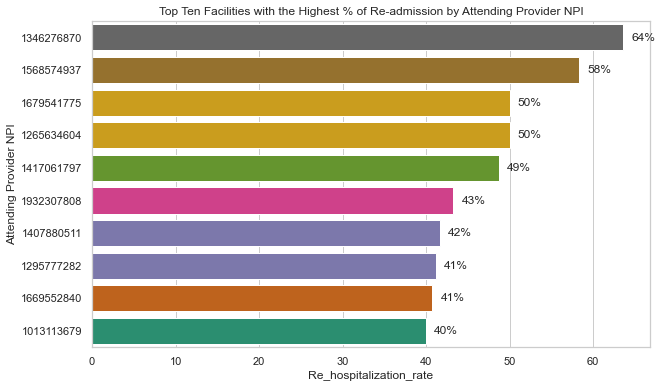

In [43]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
g = sns.barplot(x='Re_hospitalization_rate', y='Attending Provider NPI',  data=top_ten_readmission_prov_NPI, palette="Dark2_r")
plt.title('Top Ten Facilities with the Highest % of Re-admission by Attending Provider NPI')

for p in g.patches:
    width = p.get_width()    # get bar length
    g.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}%'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

### Identify Frequent Fliers by Category of Diagnostics

#### `ICD 10` codes were introduced in 2015. For all Re-admission, we will determine the Re-admission by ICD Code where year > 2015

In [45]:
re_admits_under30d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 696 entries, 34 to 6210
Data columns (total 11 columns):
 #   Column                                               Non-Null Count  Dtype          
---  ------                                               --------------  -----          
 0   Encounter ID                                         696 non-null    object         
 1   Patient ID                                           696 non-null    object         
 2   Attending Provider NPI                               696 non-null    object         
 3   Facility Provider NPI                                696 non-null    object         
 4   Encounter Start Date                                 696 non-null    datetime64[ns] 
 5   Encounter End Date                                   696 non-null    datetime64[ns] 
 6   Principal Discharge Diagnosis ICD-10-CM Code         501 non-null    object         
 7   Principal Discharge Diagnosis ICD-10-CM Description  492 non-null    object   

From the Above informaiton, It seems like has 501 ICD10 codes vs 696 records. Despite that, we will continue to move forward. We also understand that Description is 492 records only

In [55]:
diagnostics = re_admits_under30d.groupby('Principal Discharge Diagnosis ICD-10-CM Code', as_index=False)['Encounter ID'].count()
diagnostics = diagnostics.sort_values((['Encounter ID']), ascending=False)
diagnostics

,Principal Discharge Diagnosis ICD-10-CM Code,Encounter ID
323,Z51.11,38
14,A41.9,22
62,D70.9,7
319,Z38.00,6
255,O48.0,6
...,...,...
123,I63.50,1
121,I63.211,1
120,I62.00,1
119,I61.9,1


Text(0.5, 0, 'Re-Admission Counts')

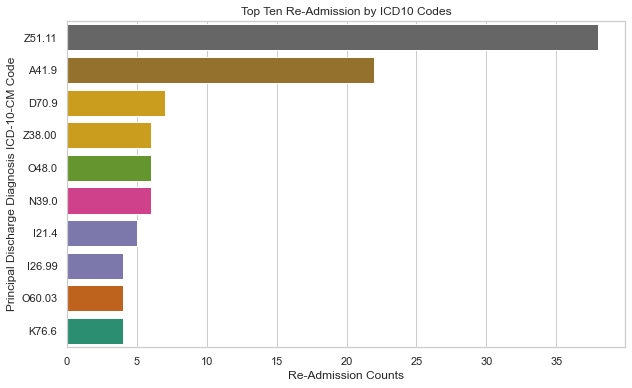

In [66]:
diagnostics10 = diagnostics.nlargest(10, 'Encounter ID')

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
g = sns.barplot(x='Encounter ID', y='Principal Discharge Diagnosis ICD-10-CM Code',  data=diagnostics10, palette="Dark2_r")
plt.title('Top Ten Re-Admission by ICD10 Codes')
plt.xlabel('Re-Admission Counts')

In [63]:
# Lets Merge the admission dataframe to add the Description to the Codes
ICD10 = admissions1[['Principal Discharge Diagnosis ICD-10-CM Code','Principal Discharge Diagnosis ICD-10-CM Description']]

final_diagnostic_readmission = pd.merge(diagnostics, ICD10, on='Principal Discharge Diagnosis ICD-10-CM Code', how='inner')
final_diagnostic_readmission


,Principal Discharge Diagnosis ICD-10-CM Code,Encounter ID,Principal Discharge Diagnosis ICD-10-CM Description
0,Z51.11,38,Encounter for antineoplastic chemotherapy
1,Z51.11,38,Encounter for antineoplastic chemotherapy
2,Z51.11,38,Encounter for antineoplastic chemotherapy
3,Z51.11,38,Encounter for antineoplastic chemotherapy
4,Z51.11,38,Encounter for antineoplastic chemotherapy
...,...,...,...
2173,I62.00,1,"Nontraumatic subdural hemorrhage, unspecified"
2174,I61.9,1,"Nontraumatic intracerebral hemorrhage, unspeci..."
2175,I61.9,1,"Nontraumatic intracerebral hemorrhage, unspeci..."
2176,K65.0,1,Generalized (acute) peritonitis


#### C. Review PCP dataframe of Patients that visited the PCP group in 7 days after exiting the hospital by Provider Group NPI